# Physical simualtion with NVIDIA Warp



### *Copyright 2021-today Dr. George Papagiannakis,  papagian@csd.uoc.gr*
*All Rights Reserved*
### *University of Crete & Foundation for Research & Technology - Hellas (FORTH)*

Documentation for the NVIDIA Warp simulator can be found [here](https://docs.nvidia.com/cuda/warp/index.html).

In [ ]:
import warp as wp
import numpy as np

wp.init()

num_points = 1024

@wp.kernel
def length(points: wp.array(dtype=wp.vec3),
           lengths: wp.array(dtype=float)):

    # thread index
    tid = wp.tid()

    # compute distance of each point from origin
    lengths[tid] = wp.length(points[tid])


# allocate an array of 3d points
points = wp.array(np.random.rand(num_points, 3), dtype=wp.vec3)
lengths = wp.zeros(num_points, dtype=float)

# launch kernel
wp.launch(kernel=length,
          dim=len(points),
          inputs=[points, lengths])

print(lengths)

	Module __main__ load on device 'cpu' took 331.40 ms
render took 437.27 ms


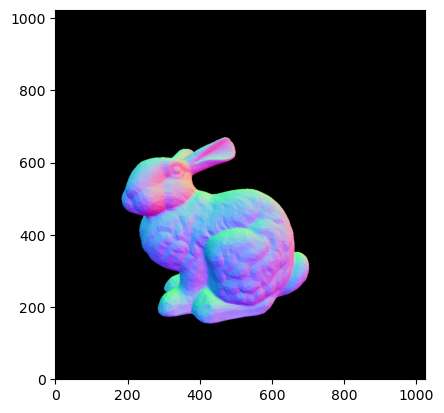

In [7]:
# Copyright (c) 2022 NVIDIA CORPORATION.  All rights reserved.
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

#############################################################################
# Example Ray Cast
#
# Shows how to use the built-in wp.Mesh data structure and wp.mesh_query_ray()
# function to implement a basic ray-tracer.
#
##############################################################################

import os

import numpy as np
from pxr import Usd, UsdGeom

import warp as wp

wp.init()


@wp.kernel
def draw(mesh: wp.uint64, cam_pos: wp.vec3, width: int, height: int, pixels: wp.array(dtype=wp.vec3)):
    tid = wp.tid()

    x = tid % width
    y = tid // width

    sx = 2.0 * float(x) / float(height) - 1.0
    sy = 2.0 * float(y) / float(height) - 1.0

    # compute view ray
    ro = cam_pos
    rd = wp.normalize(wp.vec3(sx, sy, -1.0))

    color = wp.vec3(0.0, 0.0, 0.0)

    query = wp.mesh_query_ray(mesh, ro, rd, 1.0e6)
    if query.result:
        color = query.normal * 0.5 + wp.vec3(0.5, 0.5, 0.5)

    pixels[tid] = color


class Example:
    def __init__(self, **kwargs):
        self.width = 1024
        self.height = 1024
        self.cam_pos = (0.0, 1.0, 2.0)

        #asset_stage = Usd.Stage.Open(os.path.join(os.path.dirname(__file__), "data/bunny.usd"))
        asset_stage = Usd.Stage.Open("./data/bunny.usd")
        mesh_geom = UsdGeom.Mesh(asset_stage.GetPrimAtPath("/bunny/bunny"))

        points = np.array(mesh_geom.GetPointsAttr().Get())
        indices = np.array(mesh_geom.GetFaceVertexIndicesAttr().Get())

        self.pixels = wp.zeros(self.width * self.height, dtype=wp.vec3)

        # create wp mesh
        self.mesh = wp.Mesh(
            points=wp.array(points, dtype=wp.vec3), velocities=None, indices=wp.array(indices, dtype=int)
        )

    def update(self):
        pass

    def render(self):
        with wp.ScopedTimer("render"):
            wp.launch(
                kernel=draw,
                dim=self.width * self.height,
                inputs=[self.mesh.id, self.cam_pos, self.width, self.height, self.pixels],
            )


if __name__ == "__main__":
    import matplotlib.pyplot as plt

    example = Example()
    example.render()

    wp.synchronize_device()

    plt.imshow(
        example.pixels.numpy().reshape((example.height, example.width, 3)), origin="lower", interpolation="antialiased"
    )
    plt.show()

In [9]:
# Copyright (c) 2022 NVIDIA CORPORATION.  All rights reserved.
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

import numpy as np


def eval_springs(x, v, indices, rest, ke, kd, f):
    i = indices[:, 0]
    j = indices[:, 1]

    xi = x[i]
    xj = x[j]

    vi = v[i]
    vj = v[j]

    xij = xi - xj
    vij = vi - vj

    l = np.linalg.norm(xij, axis=1)
    l_inv = 1.0 / l

    # normalized spring direction
    dir = (xij.T * l_inv).T

    c = l - rest
    dcdt = np.sum(dir * vij, axis=1)

    # damping based on relative velocity.
    fs = dir.T * (ke * c + kd * dcdt)

    np.add.at(f, i, -fs.T)
    np.add.at(f, j, fs.T)


def integrate_particles(x, v, f, w, dt):
    g = np.array((0.0, 0.0 - 9.8, 0.0))
    s = w > 0.0

    a_ext = g * s[:, None]

    # simple semi-implicit Euler. v1 = v0 + a dt, x1 = x0 + v1 dt
    v += ((f.T * w).T + a_ext) * dt
    x += v * dt

    # clear forces
    f *= 0.0


class NpIntegrator:
    def __init__(self, cloth):
        self.cloth = cloth

        self.forces = np.zeros((self.cloth.num_particles, 3), dtype=np.float32)

    def simulate(self, dt, substeps):
        sim_dt = dt / substeps

        for s in range(substeps):
            eval_springs(
                self.cloth.positions,
                self.cloth.velocities,
                self.cloth.spring_indices.reshape((self.cloth.num_springs, 2)),
                self.cloth.spring_lengths,
                self.cloth.spring_stiffness,
                self.cloth.spring_damping,
                self.forces,
            )

            # integrate
            integrate_particles(self.cloth.positions, self.cloth.velocities, self.forces, self.cloth.inv_masses, sim_dt)

        return self.cloth.positions

In [11]:
# Copyright (c) 2022 NVIDIA CORPORATION.  All rights reserved.
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

###########################################################################
# Example Mesh
#
# Shows how to implement a PBD particle simulation with collision against
# a deforming triangle mesh. The mesh collision uses wp.mesh_query_point_sign_normal()
# to compute the closest point, and wp.Mesh.refit() to update the mesh
# object after deformation.
#
###########################################################################

import os

import numpy as np
from pxr import Usd, UsdGeom

import warp as wp
import warp.render

wp.init()


@wp.kernel
def deform(positions: wp.array(dtype=wp.vec3), t: float):
    tid = wp.tid()

    x = positions[tid]

    offset = -wp.sin(x[0]) * 0.02
    scale = wp.sin(t)

    x = x + wp.vec3(0.0, offset * scale, 0.0)

    positions[tid] = x


@wp.kernel
def simulate(
    positions: wp.array(dtype=wp.vec3),
    velocities: wp.array(dtype=wp.vec3),
    mesh: wp.uint64,
    margin: float,
    dt: float,
):
    tid = wp.tid()

    x = positions[tid]
    v = velocities[tid]

    v = v + wp.vec3(0.0, 0.0 - 9.8, 0.0) * dt - v * 0.1 * dt
    xpred = x + v * dt

    max_dist = 1.5

    query = wp.mesh_query_point_sign_normal(mesh, xpred, max_dist)
    if query.result:
        p = wp.mesh_eval_position(mesh, query.face, query.u, query.v)

        delta = xpred - p

        dist = wp.length(delta) * query.sign
        err = dist - margin

        # mesh collision
        if err < 0.0:
            n = wp.normalize(delta) * query.sign
            xpred = xpred - n * err

    # pbd update
    v = (xpred - x) * (1.0 / dt)
    x = xpred

    positions[tid] = x
    velocities[tid] = v


class Example:
    def __init__(self, stage):
        self.num_particles = 1000

        self.sim_steps = 500
        self.sim_dt = 1.0 / 60.0

        self.sim_time = 0.0
        self.sim_timers = {}

        self.sim_margin = 0.1

        self.renderer = wp.render.UsdRenderer(stage)

        usd_stage = Usd.Stage.Open("data/bunny.usd")
        usd_geom = UsdGeom.Mesh(usd_stage.GetPrimAtPath("/bunny/bunny"))
        usd_scale = 10.0

        # create collision mesh
        self.mesh = wp.Mesh(
            points=wp.array(usd_geom.GetPointsAttr().Get() * usd_scale, dtype=wp.vec3),
            indices=wp.array(usd_geom.GetFaceVertexIndicesAttr().Get(), dtype=int),
        )

        # random particles
        init_pos = (np.random.rand(self.num_particles, 3) - np.array([0.5, -1.5, 0.5])) * 10.0
        init_vel = np.random.rand(self.num_particles, 3) * 0.0

        self.positions = wp.from_numpy(init_pos, dtype=wp.vec3)
        self.velocities = wp.from_numpy(init_vel, dtype=wp.vec3)

    def update(self):
        with wp.ScopedTimer("simulate", detailed=False, dict=self.sim_timers):
            wp.launch(kernel=deform, dim=len(self.mesh.points), inputs=[self.mesh.points, self.sim_time])

            # refit the mesh BVH to account for the deformation
            self.mesh.refit()

            wp.launch(
                kernel=simulate,
                dim=self.num_particles,
                inputs=[self.positions, self.velocities, self.mesh.id, self.sim_margin, self.sim_dt],
            )

            self.sim_time += self.sim_dt

    def render(self, is_live=False):
        with wp.ScopedTimer("render", detailed=False):
            time = 0.0 if is_live else self.sim_time

            self.renderer.begin_frame(time)
            self.renderer.render_mesh(name="mesh", points=self.mesh.points.numpy(), indices=self.mesh.indices.numpy())
            self.renderer.render_points(name="points", points=self.positions.numpy(), radius=self.sim_margin)
            self.renderer.end_frame()


if __name__ == "__main__":
    stage_path = os.path.join( "data/example_mesh.usd")

    example = Example(stage_path)

    for i in range(example.sim_steps):
        example.update()
        example.render()

    example.renderer.save()

	Module __main__ load on device 'cpu' took 417.32 ms
simulate took 418.35 ms
render took 9.30 ms
simulate took 0.45 ms
render took 0.21 ms
simulate took 0.40 ms
render took 0.15 ms
simulate took 0.39 ms
render took 0.14 ms
simulate took 0.39 ms
render took 0.15 ms
simulate took 0.40 ms
render took 0.15 ms
simulate took 0.42 ms
render took 0.22 ms
simulate took 0.45 ms
render took 0.20 ms
simulate took 0.48 ms
render took 0.32 ms
simulate took 0.46 ms
render took 0.18 ms
simulate took 0.41 ms
render took 0.17 ms
simulate took 0.40 ms
render took 0.16 ms
simulate took 0.40 ms
render took 0.15 ms
simulate took 0.40 ms
render took 0.16 ms
simulate took 0.40 ms
render took 0.16 ms
simulate took 0.40 ms
render took 0.15 ms
simulate took 0.41 ms
render took 0.15 ms
simulate took 0.42 ms
render took 0.16 ms
simulate took 0.42 ms
render took 0.15 ms
simulate took 0.42 ms
render took 0.15 ms
simulate took 0.42 ms
render took 0.15 ms
simulate took 0.43 ms
render took 0.15 ms
simulate took 0.43 ms

: 